**1. Project description:**
The aim of this project is to build a forecasting model that predicts sales for a single product comercialized in 1115 stores. The end results will be used in the supply chain process and for the projection of the monthly revenue. The data covers 2.5 years of daily sales. Also, the dataset contains information about promotions, the daily number of customers, and 2 types of holidays (school and state).

**2. Solution:**
Project structure:
- Understanding, cleaning, and exploring data (exploratory_data_analysis.ipynb);
- Data modeling & validation (sales_forecasting/api/model.py)
- Feature engineering (sales_forecasting/utils/feature_engineering.py);
- Experimenting with machine learning models (LightGBMRegressor, Random Forest) (machine_learning.ipynb)
- Choosing the final models and evaluation (machine_learning.ipynb, sales_forecasting/utils/ml.py)

**Metric:**
The metric used for evaluation is Symmetric Mean Absolute Percentage Error (SMAPE) at daily, weekly and monthly granularities.

**Implementation particularities:**
After the data exploration and modeling, I have decided to create 3 machine learning models using the Random Forest Regressor algorithm. 
The models will be created for different type of stores: non-stop stores, normal stores and stores that contain gaps in data.

In [32]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from pydantic import parse_obj_as
from typing import List
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

import warnings
warnings.filterwarnings('ignore')

In [29]:
from sales_forecasting.api.model import RequestSchema
from sales_forecasting.utils.feature_engineering import calendar_features, incomplete_data_stores
from sales_forecasting.utils.ml import  results_df, results_keeper, final_results_keeper, prediction_metrics_and_result_keeper, smape, error, store_train_test_selection, model_selection_specific_store, train_test_validate_split_on_date, predicted_vs_real_plot
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,accuracy_score
import optuna

In [4]:
models=[]
daily_smape=[]
weekly_smape=[]
monthly_smape=[]
percentage_error_model=[]
list_of_incomplete_stores=[]
store=[]


In [5]:
raw_sales_data = pd.read_csv('sales_per_store_per_day.csv', 
    dtype={'Store':'Int64','DayOfWeek':'Int64','Sales':'Int64','Customers':'Int64','Open':'Int64','Promo':'Int64',
           'StateHoliday':'str','SchoolHoliday':'Int64'}, parse_dates=['Date'])

raw_dict = raw_sales_data.to_dict(orient='records')
validated_sales = parse_obj_as(List[RequestSchema], raw_dict)

del raw_sales_data, raw_dict
gc.collect()

sales_df=pd.DataFrame([item.dict() for item in validated_sales])
del validated_sales 
gc.collect()

0

## Feature engineering

In [6]:
sales_df['sales_date'] = pd.to_datetime(sales_df['sales_date'])
sales_df['close_flag'] = np.where(sales_df['open_flag'] == 1, 0, 1)
sales_df['state_holiday_flag']=np.where(sales_df['state_holiday'] == '0', 0, 1)
sales_df = calendar_features(sales_df)
sales_df['week_of_year'] = sales_df['week_of_year'].astype(int)

In [33]:
sales_df

,sales_date,store,sales,customers,open_flag,promo,day_of_week,state_holiday,school_holiday,close_flag,state_holiday_flag,year,month,day_of_month,day_of_year,week_of_year,odd_weeks
0,2015-06-30,1,5735,568,1,1,2,0,0,0,0,2015,6,30,181,27,1
1,2015-06-30,2,9863,877,1,1,2,0,0,0,0,2015,6,30,181,27,1
2,2015-06-30,3,13261,1072,1,1,2,0,1,0,0,2015,6,30,181,27,1
3,2015-06-30,4,13106,1488,1,1,2,0,0,0,0,2015,6,30,181,27,1
4,2015-06-30,5,6635,645,1,1,2,0,0,0,0,2015,6,30,181,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982639,2013-01-01,1111,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982640,2013-01-01,1112,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982641,2013-01-01,1113,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982642,2013-01-01,1114,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1


### Explore Machine Learning models on one store

In [34]:
one_store = sales_df[sales_df['store']==85].copy()
x_train, y_train, x_test, y_test, x_validate, y_validate = train_test_validate_split_on_date(one_store.drop(columns=['store','customers','state_holiday']), 
                                                                                             datetime(2015,3,1), 
                                                                                             datetime(2015,5,1), 
                                                                                             datetime_col = 'sales_date', output_col='sales')

## LGBMRegressor

In [11]:
# EXPERIMENT_NAME = "sales_forecasting"
# EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
#EXPERIMENT_ID =  '292628267100658798'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 9
[LightGBM] [Info] Start training from score 7205.685678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

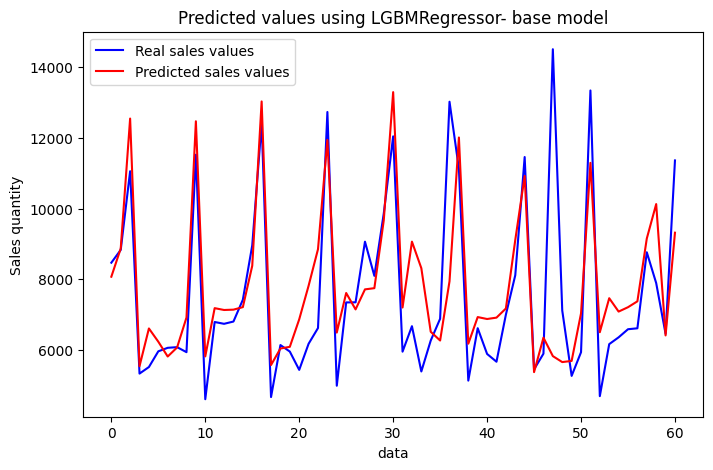

In [12]:

EXPERIMENT_NAME = "sales_forecasting"
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='base_model_2') as run:
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    predicted_vs_real_plot(y_test, y_pred_lgb, title='Predicted values using LGBMRegressor- base model', image_name='real_vs_predicted')
    
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.lightgbm.log_model(model, 'model')
    mlflow.log_artifact("real_vs_predicted.png")

## Hyperparameter optimization using Optuna

In [ ]:
import optuna
from sklearn.metrics import mean_squared_error

def objective_lgbm(trial,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    param = {
        'metric': 'rmse', 
        'random_state': 1,
        'objective':'regression',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 50.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
        'colsample_bytree': trial.suggest_loguniform("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_loguniform("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
        'max_depth': trial.suggest_int("max_depth", 1, 40),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 40),
        'min_child_samples': trial.suggest_int('min_child_samples',3, 300)
    }
    model = LGBMRegressor(**param)  
    model.fit(x_train,y_train,eval_set=[(x_validate,y_validate)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(x_validate)
    rmse = mean_squared_error(y_validate, preds,squared=False)
    
    return rmse
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=200)
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)
best_lgbm_params=study_lgbm.best_params

## LGBMRegressor Model with best parametrs

In [13]:
best_lgbm_params = {'n_estimators': 842, 'reg_alpha': 0.002969430627130082, 'reg_lambda': 0.03294285726465247, 'colsample_bytree': 0.18845474243951735, 'subsample': 0.2311177367960193, 'learning_rate': 0.06541730688744178, 'max_depth': 32, 'num_leaves': 22, 'min_child_samples': 14}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 10
[LightGBM] [Info] Start training from score 7205.685678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

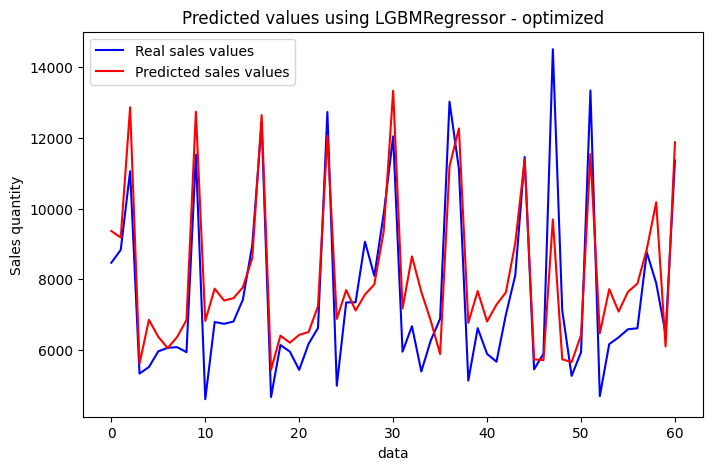

In [14]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='optimized_lgbm') as run:
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model.set_params(**best_lgbm_params)
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.lightgbm.log_model(model, 'model')

    predicted_vs_real_plot(y_test, y_pred_lgb, title='Predicted values using LGBMRegressor - optimized', image_name='real_vs_predicted_lgbm_final')
    mlflow.log_artifact("real_vs_predicted_lgbm_final.png")

## RandomForestRegressor

In [19]:
def objective_rf(trial,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    
    param = {
        'random_state': 1,
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'max_features': trial.suggest_int('max_features', 1, 12)
    }
    model = RandomForestRegressor(**param)  
    model.fit(x_train,y_train)
    preds = model.predict(x_validate)
    rmse = mean_squared_error(y_validate, preds, squared=False)
    
    return rmse
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=200)
print('Number of finished trials:', len(study_rf.trials))
print('Best trial:', study_rf.best_trial.params)
best_rf_params=study_rf.best_params

[I 2024-05-27 11:37:37,723] A new study created in memory with name: no-name-fbc97509-d9d3-4662-b194-392b916ac5c6
[I 2024-05-27 11:37:37,996] Trial 0 finished with value: 1909.3550265677363 and parameters: {'n_estimators': 204, 'max_depth': 2, 'min_samples_leaf': 18, 'min_samples_split': 6, 'max_features': 4}. Best is trial 0 with value: 1909.3550265677363.
[I 2024-05-27 11:37:39,091] Trial 1 finished with value: 1666.4000406969985 and parameters: {'n_estimators': 773, 'max_depth': 12, 'min_samples_leaf': 19, 'min_samples_split': 6, 'max_features': 3}. Best is trial 1 with value: 1666.4000406969985.
[I 2024-05-27 11:37:39,185] Trial 2 finished with value: 1283.2973302231862 and parameters: {'n_estimators': 54, 'max_depth': 18, 'min_samples_leaf': 6, 'min_samples_split': 5, 'max_features': 3}. Best is trial 2 with value: 1283.2973302231862.
[I 2024-05-27 11:37:40,989] Trial 3 finished with value: 1071.7364894192283 and parameters: {'n_estimators': 975, 'max_depth': 17, 'min_samples_leaf

Number of finished trials: 200
Best trial: {'n_estimators': 396, 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 12}


## Model RandomForestRegressor

In [20]:
best_rf_params = {'n_estimators': 308, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 12}

Total value of sales on test predicted interval: 462814
Absolute error:  36776
Percentage error reported to real sales: 1.49%
Daily SMAPE is: 7.93 %
Weekly SMAPE is: 4.36 %
Monthly SMAPE is: 2.71 %


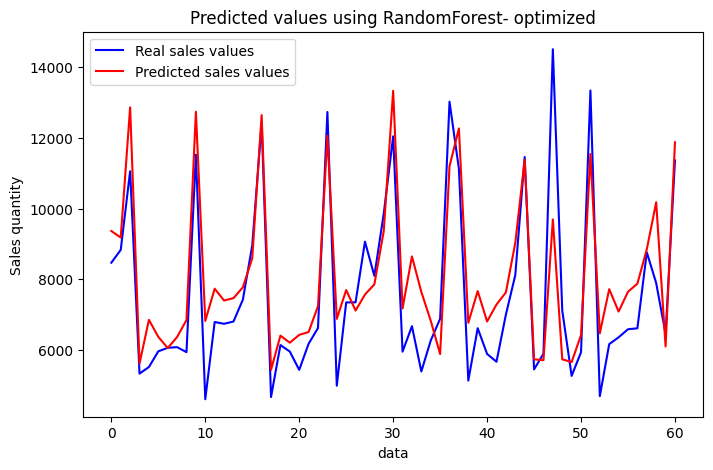

In [21]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='optimized_rf') as run:
    # Retrieve run id
    RUN_ID = run.info.run_id
    model = RandomForestRegressor(**best_rf_params)
    model = model.fit(x_train, y_train)
    y_pred_rf = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_rf, model)
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.sklearn.log_model(model, 'model')

    plt.figure(figsize=(8,5))  
    plt.plot(y_test.values, color='blue', label='Real sales values')  
    plt.plot(y_pred_lgb , color='red', label='Predicted sales values')  
    plt.title('Predicted values using RandomForest- optimized')  
    plt.xlabel('data')  
    plt.ylabel('Sales quantity')  
    plt.legend()
    plt.savefig("real_vs_predicted.png")  
    plt.show()
    mlflow.log_artifact("real_vs_predicted.png")

## Comparative results

In [22]:
# create a model selection dataframe for best model determination
models[0] = 'LGBMRegressor - base'
model_selection = pd.DataFrame({'Model': models, 'daily_smape': daily_smape, 'weekly_smape': weekly_smape, 'monthly_smape' :monthly_smape, 'percentage_error': percentage_error_model})
model_selection.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection.style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())

,Model,daily_smape,weekly_smape,monthly_smape,percentage_error
0,LGBMRegressor - base,13.450000,7.310000,9.000000,3.150000
1,LGBMRegressor,12.600000,7.970000,5.510000,6.190000
2,RandomForestRegressor,7.930000,4.360000,2.710000,1.490000


In [50]:
# create a model selection dataframe for best model determination
models[1] = 'LGBMRegressor'
model_selection = pd.DataFrame({'Model': models, 'daily_smape': daily_smape, 'weekly_smape': weekly_smape, 'monthly_smape' :monthly_smape, 'percentage_error': percentage_error_model})
model_selection.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection.style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())

,Model,daily_smape,weekly_smape,monthly_smape,percentage_error
0,LGBMRegressor - base,13.450000,7.310000,9.000000,3.150000
1,LGBMRegressor,12.600000,7.970000,5.510000,6.190000
2,RandomForestRegressor,7.930000,4.360000,2.710000,1.490000


In [23]:
#pip install shap
import shap

In [49]:
models[1]

'LGBMRegressor'

In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

NameError: name 'y_pred' is not defined

In [24]:
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# Creează un obiect explainer SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)


In [25]:
shap.summary_plot(shap_values[1], x_test, plot_type="bar")

# Vizualizează explicațiile detaliate pentru prima instanță din setul de date de testare
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

AssertionError: Summary plots need a matrix of shap_values, not a vector.